## Libraries

In [2]:
# from model import PrintRollModel
import pandas as pd
from datetime import date
import seaborn as sns
from enum import Enum
import simpy
import random
import matplotlib.pylab as plt

### Classes

In [3]:
# Enum to represent time
class QueueEventType(Enum):
    ENTERED_QUEUE = 1
    LEFT_QUEUE = 2
    PROCESSING_TIME = 3


# Basic Structure of a roll class. This class will represente
class Roll:
    def __init__(self, id, created_at, material=None, material_type=None, length=None):
        self.id = id
        self.material = material
        self.material_type = material_type
        self.length = length
        self.time_in_print_node = {
            "entered_queue": None,
            "left_queue": None,
            "wait_time": None,
            "processing_time": None,
            "printed_at": None,
            "created_at": created_at,
            "assigned_at": None,
        }
        self.assigned_to = None

    def update_time_in_print(self, type_of_event: QueueEventType, ts):
        # Logging time when the roll joined the queue to be printed
        if type_of_event == QueueEventType.ENTERED_QUEUE:
            self.time_in_print_node["entered_queue"] = ts

        # Logging time when the roll left the queue. Also calculating how many minutes it spent in said queue
        elif type_of_event == QueueEventType.LEFT_QUEUE:
            self.time_in_print_node["left_queue"] = ts
            self.calculate_wait_time()

        # Calculating how many minutes took the printing proccess.
        # Logging time when roll was printed.
        elif type_of_event == QueueEventType.PROCESSING_TIME:
            self.time_in_print_node["printed_at"] = ts
            self.time_in_print_node["processing_time"] = (
                ts - self.time_in_print_node["left_queue"]
            )

    def calculate_wait_time(self):
        self.time_in_print_node["wait_time"] = (
            self.time_in_print_node["left_queue"]
            - self.time_in_print_node["entered_queue"]
        )

    def assign_to_printer(self, printer, assigned_at):
        self.assigned_to = printer
        self.time_in_print_node["assigned_at"] = assigned_at


# Model to print a
class PrintRollModel:
    def __init__(self, log_output=True, sim_id=0):
        # Adding a starting time to the simulation!
        self.env = simpy.Environment(
            initial_time=GlobalParamaters.INITIAL_SIMULATION_TIME
        )

        # Placeholder for roll_id
        self.roll_counter = 0
        self.rolls = []

        # To control if we want to log an output
        self.log_output = log_output

        self.sim_id = sim_id

        # Creating Different Print Rooms
        self.print_rooms = [
            PrintRoom(
                self.env,
                name=printer["PRINTER_NAME"],
                approved_materials=printer["MATERIAL_CAPABILITIES"],
                capacity=GlobalParamaters.PRINTER_PER_PRINT_ROOM,
            )
            for printer in GlobalParamaters.PRINTERS_CONFIGURATION
        ]
        self.printer = simpy.Resource(
            self.env, capacity=GlobalParamaters.NUMBER_OF_PRINTERS
        )

    # Arrival Rolls Generator
    def generate_ready_for_print_rolls(self):
        # Keep Generating rolls
        while True:
            self.roll_counter += 1

            # Creating a new roll
            roll_to_print = Roll(
                id=self.roll_counter,
                created_at=self.env.now,
                material=random.choice(GlobalParamaters.MATERIAL_LIST),
            )

            # Appending the roll object to analyze.
            self.rolls.append(roll_to_print)

            # Send the created roll to print
            self.env.process(self.print_roll(roll_to_print))

            # Randomly sampling the time that a new roll will be ready for print.
            # This will simulate the ONE Node.
            sample_inter_arrival = random.expovariate(
                1.0 / GlobalParamaters.ROLL_RIPPED_INTER_TIME
            )

            # Freeze the function until that time has elapsed
            yield self.env.timeout(sample_inter_arrival)

    # Method to model the processes of printing a roll
    # Needs to be passed a roll who will go through these processes.
    def print_roll(self, roll: Roll):
        roll.update_time_in_print(QueueEventType.ENTERED_QUEUE, self.env.now)

        if self.log_output:
            print(
                f"Roll {roll.id} entered queue at {roll.time_in_print_node['entered_queue']}"
            )

        # Now we need to request a printer
        assigned_print_room = self.assign_print_room(roll)

        if self.log_output:
            print(f"Roll {roll.id} assigned to {assigned_print_room.name}")

        roll.assign_to_printer(assigned_print_room.name, self.env.now)
        with assigned_print_room.printers.request() as req:
            # Freeze until the request for a printer can be met
            yield req

            # Calculate time roll was in the queue to be printed
            roll.update_time_in_print(QueueEventType.LEFT_QUEUE, self.env.now)
            if self.log_output:
                print(
                    f"Roll {roll.id} started to print at {roll.time_in_print_node['left_queue']}"
                )

                print(
                    f"Roll {roll.id} queued for {roll.time_in_print_node['wait_time']} minutes"
                )

            # Randomly sample a time that the roll spent while being printed
            # Right now using a normal distribution but this will change
            # Roll printing time can be the roll.lenght * printer speed... And we can sample a loading roll time.. and sum to that
            sample_printing_time = random.gauss(
                GlobalParamaters.MEAN_PRINT_TIME, GlobalParamaters.STDEV_PRINT_TIME
            )

            # Freeze the function until that time has passed (simulating that the roll is being printed)
            yield self.env.timeout(sample_printing_time)
            roll.update_time_in_print(QueueEventType.PROCESSING_TIME, self.env.now)

    # Here is where we are going to select an optimal printer,
    # Simulating Printer Assignment
    def assign_print_room(self, roll: Roll):

        # TODO:
        # ADD Shift.
        shuffled = list(
            zip(range(len(self.print_rooms)), self.print_rooms)
        )  # tuples of (i, line)

        #  Printers are shuffled so that the first queue is not disproportionally selected
        random.shuffle(shuffled)
        shortest_queue = shuffled[0][0]

        # Selecting the Print Room with the Shortest Queue and that accepts the roll's material.
        # This can be improved
        for i, print_room in shuffled:
            if (
                len(print_room.printers.queue)
                <= len(self.print_rooms[shortest_queue].printers.queue)
                and roll.material in print_room.approved_materials
            ):
                shortest_queue = i
        return self.print_rooms[shortest_queue]

    # Function that returns the dataFrame
    def get_rolls_data(self, data_type="dataframe"):
        # Return the list of objects
        if data_type == "list":
            return self.rolls

        # Returns a Dataframe
        elif data_type == "dataframe":
            # Adding a new dataframe to store the rolls
            historical_rolls_df = pd.DataFrame(
                columns=[
                    "sim_id",
                    "roll_id",
                    "created_at",
                    "material",
                    "assigned_at",
                    "entered_print_queue_at",
                    "left_print_queue_at",
                    "minutes_waiting_in_queue",
                    "printed_at",
                    "processing_time",
                    "printed_assigned_to",
                ]
            )
            for roll in self.rolls:
                # Appending the roll data to a dataframe
                historical_rolls_df = historical_rolls_df.append(
                    {
                        "sim_id": self.sim_id,
                        "roll_id": roll.id,
                        "created_at": roll.time_in_print_node["created_at"],
                        "material": roll.material,
                        "assigned_at": roll.time_in_print_node["assigned_at"],
                        "entered_print_queue_at": roll.time_in_print_node[
                            "entered_queue"
                        ],
                        "left_print_queue_at": roll.time_in_print_node["left_queue"],
                        "minutes_waiting_in_queue": roll.time_in_print_node[
                            "wait_time"
                        ],
                        "printed_at": roll.time_in_print_node["printed_at"],
                        "processing_time": roll.time_in_print_node["processing_time"],
                        "printed_assigned_to": roll.assigned_to,
                    },
                    ignore_index=True,
                )

            return historical_rolls_df

    # This method will kickoff the simulation and will tell simpy to start running the environment.
    def run(self):
        self.env.process(self.generate_ready_for_print_rolls())
        self.env.run(until=GlobalParamaters.SIMULATION_DURATION)


# PrintRoom model that will simulate a the operations of a Print Room in Resonance.
#
class PrintRoom:
    def __init__(
        self,
        env,
        name,
        capacity=1,
        approved_materials=None,
        shift_starts=None,
        shift_ends=None,
    ):
        self.name = name
        self.capacity = capacity
        self.approved_materials = approved_materials
        self.shift_starts = shift_starts
        self.shift_ends = shift_ends
        self.printers = simpy.Resource(env, capacity=capacity)

    def set_shifts(self, shift_starts, shift_ends):
        self.shift_starts = shift_starts
        self.shift_ends = shift_ends

    def set_approved_materials(self, approved_material_list):
        self.approved_materials = approved_material_list


## Helper Functions

In [4]:
def transform_to_real_timestamps(df):
    columns = ["created_at", "assigned_at", "entered_print_queue_at", "left_print_queue_at", "printed_at"]
    for column in columns:
        df[column] = TODAY + pd.to_timedelta(df[column],unit="m")
    return df

def generate_date_spine(starting_date, starting_time=0, end_time = 0, increment_by=0):
    if end_time == 0:
        end_time = starting_time *  2
        
    return [starting_date + pd.to_timedelta(x,unit="m") for x in range(starting_time, end_time + increment_by, increment_by)]

def get_queue_over_time(number_of_runs, date_spine, df):
    printers = df["printed_assigned_to"].unique()
    queue_over_time_df = pd.DataFrame(columns=[
                    "sim_id",
                    "date",
                    "printer",
                    "queue_size"
                ])
    
    for run in range(number_of_runs):
        
        for printer in printers:
            # Assuming that at the start time the queues are always empty.
            queue_over_time_df = queue_over_time_df.append(
                    {
                        "sim_id": run,
                        "date": date_spine[0],
                        "printer": printer,
                        "queue_size": pd.to_numeric(0)
                    },
                    ignore_index=True,
                )

        
        for i in range(1, len(date_spine)):
            for printer in printers:
                # Creating a mask to know how the queue was like by time by printer
                temp_df = df[df["sim_id"]==run].copy()
                temp_df = temp_df[temp_df["printed_assigned_to"]==printer]
                mask = (temp_df['entered_print_queue_at'] < date_spine[i-1]) & ((temp_df['left_print_queue_at'] >= date_spine[i]) | (temp_df['left_print_queue_at'].isnull()))                
                queue_over_time_df = queue_over_time_df.append(
                    {
                        "sim_id": run,
                        "date": date_spine[i],
                        "printer": printer,
                        "queue_size": pd.to_numeric(len(temp_df.loc[mask]))
                    },
                    ignore_index=True,
                )

    return queue_over_time_df


### Paramaters

In [14]:
# Storing Global Paramaters
# Instead of creating an instance, we just access to these paramaters.
class GlobalParamaters:
    # Every how many minutes we have rolls ripped - ready to print
    ROLL_RIPPED_INTER_TIME = 2

    # Shift + Materil per Shift.
    PRINTERS_CONFIGURATION = [
        {
            "PRINTER_NAME": "JP7 LUNA",
            "MATERIAL_CAPABILITIES": [
                "OCTHR",
                "COMCT",
                "ECVIC",
                "CDCBM",
                "CHRST",
                "HC293",
                "CTNSP",
                "FBTRY",
                "CTJ95",
                "LSG19",
                "CTNBA",
            ],
        },
        {
            "PRINTER_NAME": "JP7 FLASH",
            "MATERIAL_CAPABILITIES": [
                "CHRST",
                "GGT16",
                "OCT70",
                "CTNOX",
                "OC135",
                "CT170",
                "CDCBM",
                "CUTWL",
                "SLCTN",
                "PIMA7",
                "SECTN",
                "LY100",
                "LY115",
                "LN135",
                "LTCSL",
                "RYJ01",
                "BCICT",
                "CTW70",
                "OCFLN",
                "LSG19",
            ],
        },
        {
            "PRINTER_NAME": "JP7 NOVA",
            "MATERIAL_CAPABILITIES": [
                "CC254",
                "CTSPR",
                "CT406",
                "CFTGR",
                "STCAN",
                "CTPKT",
                "OCTCJ",
                "CTNBA",
                "CFT97",
                "CTFLN",
                "CTF19",
                "CLTWL",
                "CTNL1",
                "CTNSP",
                "PIQUE",
                "CTJ95",
                "FBTRY",
                "CTNPT",
                "TNCDO",
                "HC293",
                "TNSPJ",
                "CTSPS",
            ],
        },
    ]
    MATERIAL_LIST = [
        "BCICT",
        "CC254",
        "CDCBM",
        "CFT97",
        "CFTGR",
        "CHRST",
        "CLTWL",
        "COMCT",
        "CT170",
        "CT406",
        "CTF19",
        "CTFLN",
        "CTJ95",
        "CTNBA",
        "CTNL1",
        "CTNOX",
        "CTNPT",
        "CTNSP",
        "CTPKT",
        "CTSPR",
        "CTSPS",
        "CTW70",
        "CUTWL",
        "ECVIC",
        "FBTRY",
        "GGT16",
        "HC293",
        "LN135",
        "LSG19",
        "LTCSL",
        "LY100",
        "LY115",
        "OC135",
        "OCFLN",
        "OCT70",
        "OCTCJ",
        "OCTHR",
        "PIMA7",
        "PIQUE",
        "RYJ01",
        "SECTN",
        "SLCTN",
        "STCAN",
        "TNCDO",
        "TNSPJ",
    ]
    NUMBER_OF_PRINT_ROOMS = 3
    PRINTER_PER_PRINT_ROOM = 1
    SIMULATION_DURATION = 960
    NUMBER_OF_PRINTERS = 3
    MEAN_PRINT_TIME = 50
    STDEV_PRINT_TIME = 8
    INITIAL_SIMULATION_TIME = 480

## Simulations

In [15]:
NUMBER_OF_RUNS = 1
TODAY = pd.to_datetime(date.today())
# 8:00 AM / 08:00:00
STARTING_TIME = 480
# 5:00 PM / 17:00:00 
END_TIME = 1020
INCREMENT_BY = 30
DATE_SPINE = generate_date_spine(TODAY, STARTING_TIME, END_TIME, INCREMENT_BY)
result_dt = pd.DataFrame()
LOG_OUTPUT = False

In [16]:
for run in range(NUMBER_OF_RUNS):
    if LOG_OUTPUT:
        print(f"Simulation #{run+1} of {NUMBER_OF_RUNS}")
    print_model = PrintRollModel(log_output=LOG_OUTPUT, sim_id=run)
    print_model.run()
    result_dt = result_dt.append(transform_to_real_timestamps(print_model.get_rolls_data()))
    
    if LOG_OUTPUT:
        print("\n\n")

In [8]:
### 1 Printer Per Print room


[Text(0.5, 1.0, 'Queue Size Over Time Print Room')]

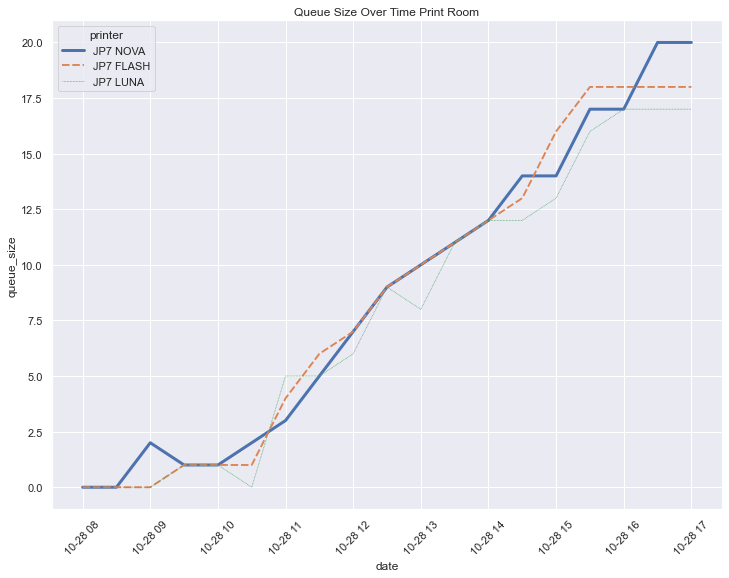

In [9]:
queue_over_time = get_queue_over_time(NUMBER_OF_RUNS, DATE_SPINE, result_dt)
sns.set(rc={'figure.figsize':(12,9)})
plt.xticks(rotation=45)
sns.lineplot(x = queue_over_time["date"], y = pd.to_numeric(queue_over_time["queue_size"]), hue=queue_over_time["printer"], size=queue_over_time["printer"], style=queue_over_time["printer"]).set(title='Queue Size Over Time Print Room')


[Text(0.5, 1.0, 'Queue Size Over Time Print Room')]

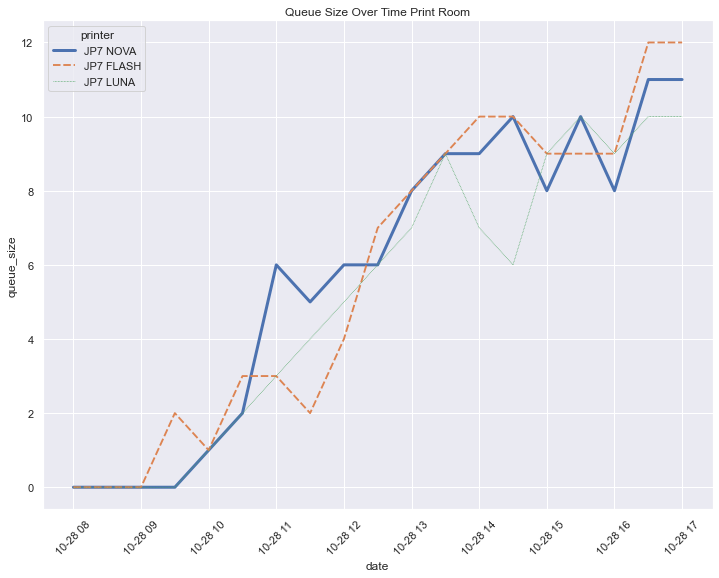

In [13]:
queue_over_time = get_queue_over_time(NUMBER_OF_RUNS, DATE_SPINE, result_dt)
sns.set(rc={'figure.figsize':(12,9)})
plt.xticks(rotation=45)
sns.lineplot(x = queue_over_time["date"], y = pd.to_numeric(queue_over_time["queue_size"]), hue=queue_over_time["printer"], size=queue_over_time["printer"], style=queue_over_time["printer"]).set(title='Queue Size Over Time Print Room')


[Text(0.5, 1.0, 'Queue Size Over Time Print Room')]

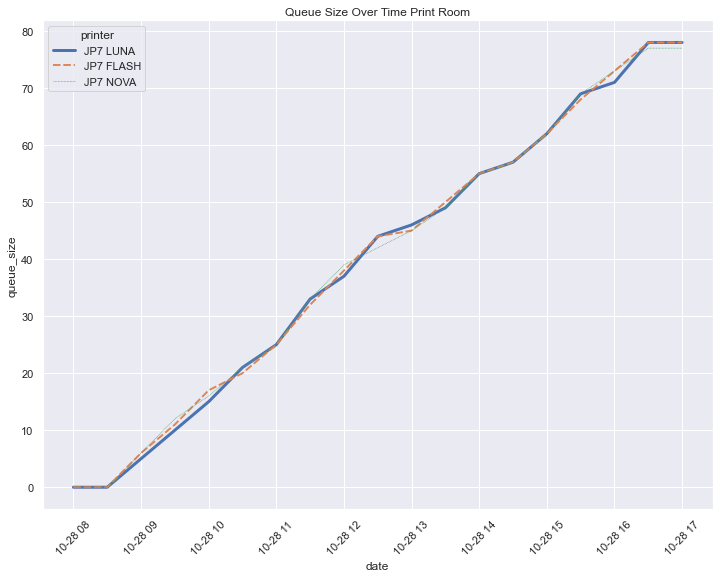

In [17]:
queue_over_time = get_queue_over_time(NUMBER_OF_RUNS, DATE_SPINE, result_dt)
sns.set(rc={'figure.figsize':(12,9)})
plt.xticks(rotation=45)
sns.lineplot(x = queue_over_time["date"], y = pd.to_numeric(queue_over_time["queue_size"]), hue=queue_over_time["printer"], size=queue_over_time["printer"], style=queue_over_time["printer"]).set(title='Queue Size Over Time Print Room')


## TODO
* Simulate shift
* Simulate errors
* Simulate wait time
* Accumulators
* Improve the metrics (realistic stats)
* Add Lenght of the roll to have an accurate print time
* 